In [1]:
from glob import iglob
from functools import reduce, partial
from itertools import product

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, size, col, lit, explode
import matplotlib.pyplot as plt
from numpy import linspace, histogramdd, array, arange, meshgrid
from numba import jit
from pyspark.sql.types import ArrayType, DoubleType

from sp8tools import SpkHits

Connect to Spark master

In [2]:
builder = (SparkSession
           .builder
           .appName("PySpark Example")
           .config("spark.jars.packages", "org.diana-hep:spark-root_2.11:0.1.15")
#            .config("spark.cores.max", 4)
           .config("spark.executor.cores", 4)
           .config("spark.executor.memory", "16g")
           )
spark = builder.getOrCreate()

Read root files

In [3]:
globbed = iglob("/helium/analysis/saito/SortEvent_aq002_t100_b.root")
roots = (spark.read.format("org.dianahep.sparkroot").load(fn) for fn in globbed)
df = reduce(DataFrame.union, roots)
df.printSchema()

root
 |-- SortedEvent: struct (nullable = true)
 |    |-- fEventID: long (nullable = true)
 |    |-- fDetektors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- fDetektors_fHits: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- fPDNbr: integer (nullable = true)
 |    |    |    |    |    |-- fHitNbr: integer (nullable = true)
 |    |    |    |    |    |-- fU1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fU2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fMcpNbr: integer (nullable = true)
 |    |    |    |    |    |-- fX_mm: double (nullable = true)
 |    |    |    |    |    |-- fY_mm: double (

Restruct

In [4]:
@udf(SpkHits)
def combine_hits(xarr, yarr, tarr, flagarr):
    return [{'x': x,
             'y': y,
             't': t,
             'flag': f
            } for x, y, t, f in zip(xarr, yarr, tarr, flagarr)]


chits = col('SortedEvent.fDetektors')[0]['fDetektors_fHits']
restructed = (df
              .withColumn('hits', combine_hits(chits.getField('fX_mm'),
                                               chits.getField('fY_mm'),
                                               chits.getField('fTime'),
                                               chits.getField('fRekmeth')))
              .select(col('SortedEvent.fEventID').alias("tag"), 'hits'))
restructed.printSchema()

root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)
 |    |    |-- as: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)



Product TOFs

In [6]:
@udf(ArrayType(ArrayType(DoubleType())))
def combinate_tofs(tarr, n):
    return list(product(tarr, repeat=n))


selected = (
    restructed
    .select(col('hits.t').alias('t'))
    .filter(size('t')!=0)
    .repartition(8)
    .cache()
)
comb1 = selected.select(explode('t').alias('t'))  # 2 MB per a part (8)
comb2 = (  # 3 MB per a part (64)
    selected
    .select(explode(combinate_tofs('t', lit(2))).alias('couple'))
    .select(*(col('couple')[i].alias('t{}'.format(i)) for i in range(2)))
)

Estimate PIPICO and background

Note that `n * covariance = PIPICO - background` including diag elements, where `n` is number of events

In [7]:
def histdd(it, n):
    arr = array(list(it))
    hist, *_ = histogramdd(
        arr,
        bins=[500]*n,
        range=[[2000, 4000]]*n,
    )
    yield hist
    return


length = selected.count()
summed1 = comb1.rdd.map(list).mapPartitions(partial(histdd, n=1)).sum()
summed2 = comb2.rdd.map(list).mapPartitions(partial(histdd, n=2)).sum()

In [10]:
edges = linspace(*[2000, 4000], 500+1)
pipico = summed2
bg = summed1[:, None]*summed1[None, :]/length
# cov2d = summed2/length - summed1[:, None]*summed1[None, :]/(length**2)

Plot

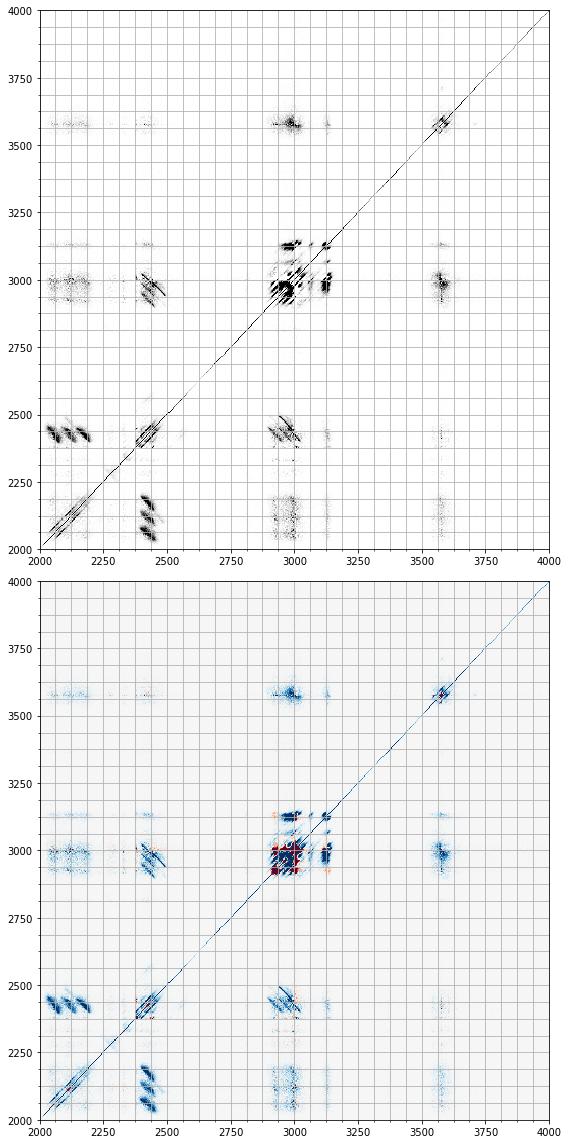

In [14]:
clim = 100

plt.figure(figsize=(8, 16))
plt.subplot(211)
plt.pcolormesh(edges, edges, (pipico - bg).T, cmap='Greys')
plt.minorticks_on()
plt.grid(which='both')
plt.clim(0, clim)

plt.subplot(212)
plt.pcolormesh(edges, edges, (pipico - bg).T, cmap='RdBu')
plt.minorticks_on()
plt.grid(which='both')
plt.clim(-clim, clim)

plt.tight_layout()
plt.show()

In [15]:
spark.stop()